# Overview
This notebook is the 3rd notebook in my Pytorch Learning journey. I am following the [ZeroToMastery Pytorch course](https://www.learnpytorch.io/02_pytorch_classification/).
This notebook will focus on Computer vision basics

In [2]:
# imports first
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as  plt

RANDOM_SEED = 69

In [3]:
# let's get ourselves some data
import os 

root_path = os.path.join(os.getcwd(), 'pytorch_data')

if not os.path.isdir(root_path):
    os.mkdir(root_path)

# let's download the data to the corresponding directory

train_data = datasets.FashionMNIST(root=root_path, 
                    train=True, # the train data
                    download=True, # download the data locally
                    transform=ToTensor() # transform the image data to tensors
                    )

test_data = datasets.FashionMNIST(root=root_path, train=False, download=True, transform=ToTensor())



c:\Users\bouab\DEV\ds_env\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# now we have our data stored locally, cool isn't ???
print(train_data.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

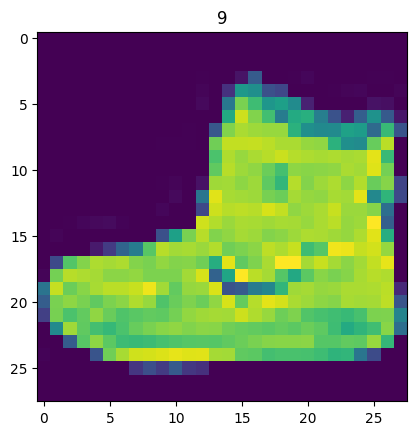

In [5]:
image, lable = train_data[0]
print(image.shape)
plt.imshow(image.squeeze())
plt.title(lable)

In [6]:
# well for computational efficiency reasons, we use Data Loaders
from torch.utils.data import DataLoader

BATCH_SIZE  = 256 # the training dataset has around 60k observations: a larger batch-size wouldn't hurt.

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, 
                batch_size=BATCH_SIZE, 
                shuffle=False # not necessary to shuffle testing data
                )


Images can have different shapes but most importanly shape's order: Channels, Height, Width or Height, Width, Channels. The latter order is considered best practice by Pytorch developers.

In [7]:
# let's try to build a baseline model
from torch import nn

class BaselineModel(nn.Module):
    def __init__(self, input_shape: tuple[int, int], num_classes:int, hidden_units: list[int]):
        # call the super class constructor
        super().__init__()

        self.num_classes = num_classes
        self.input_shape = input_shape
        # make sure if only a single integer was passed then, it is converted to a list with one element
        if isinstance(hidden_units, int):
            hidden_units = [hidden_units]

        # first thing it to add the flattening layer and the first hidden layer as
        layers = [nn.Flatten(), nn.Linear(in_features=input_shape[0] * input_shape[1], out_features=hidden_units[0])] 
        # add hidden layers
        layers.extend([nn.Linear(in_features=hidden_units[i - 1], out_features=hidden_units[i]) for i in range(1, len(hidden_units))])
        # time to add the last layer
        layers.append(nn.Linear(in_features=hidden_units[-1], out_features=(1 if num_classes <= 2 else num_classes)))

        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)


In [8]:
image, lable = train_data[0]
INPUT_SHAPE = image.squeeze().shape
print(INPUT_SHAPE)

torch.Size([28, 28])


In [9]:
model_0 = BaselineModel(input_shape=INPUT_SHAPE, num_classes=len(train_data.classes), hidden_units=[10, 10])
print(model_0)

BaselineModel(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)


In [10]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.09)

In [11]:
import torch
torch.manual_seed(69)
EPOCHS = 5

# TRAINING LOOP
for e in range(1, EPOCHS + 1):
    # first define a variable to store the model's loss
    train_loss = 0
    for batch_number, (X, y) in enumerate(train_loader):
        # first set the model to the train mode
        model_0.train() 
        # forward pass
        y_logits = model_0(X)
        # consider the predictions
        y_preds = y_logits.argmax(dim=-1)
        # calculate the loss with the logits
        batch_train_loss = loss_function(y_logits, y)
        # add the loss to the train loss
        train_loss += batch_train_loss  
        # apply the optimizer rubberish
        optimizer.zero_grad()
        batch_train_loss.backward()
        optimizer.step()
    # make sure to consider the average loss over all batches    
    train_loss /= len(train_loader)
    print(f"The training loss after epoch {e}: {train_loss}")


The training loss after epoch 1: 0.9897425770759583
The training loss after epoch 2: 0.5097190141677856
The training loss after epoch 3: 0.49029970169067383
The training loss after epoch 4: 0.4799225926399231
The training loss after epoch 5: 0.5353366136550903


ImportError: cannot import name 'accuray_fn' from 'helper_functions' (c:\Users\bouab\DEV\Towards_Data_Science\Programming_Tools\Pytorch\helper_functions.py)

In [13]:

# TESTING LOOP
# let's consider the
test_loss, test_acc = 0, 0
# first set the model to the evaluation mode
model_0.eval()

from helper_functions import accuracy_fn 

with torch.inference_mode():
    for X, y in test_loader:
        test_logits = model_0(X)
        # let's calculate the loss
        test_loss += loss_function(test_logits, y)
        # calculate the metric
        test_acc += accuracy_fn(y, test_logits.argmax(dim=-1))
    # at the end don't forget to average over the number of batches
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
   


In [15]:
print(test_loss.item())
print(test_acc)

0.5507522821426392
81.30859375


## CNNS

In [50]:
def dimensions_after_convolution(dims: tuple[int, int], kernel_size:tuple[int, int], padding:tuple[int, int], stride:int):
    k1, k2 = kernel_size
    p1, p2 = padding
    d1, d2 = dims
    s1, s2 = stride
    return (int((d1 + 2 * p1 - k1) / s1) + 1, int((d2 + 2 * p2 - k2) / s2) + 1)

def dimensions_after_pooling(dims: tuple[int, int], kernel_size:tuple[int, int], stride:int):
    d1, d2 = dims
    k1, k2 = kernel_size
    s1, s2 = stride
    return (int((d1 - k1)/ s1) + 1, int((d2 - k2 / s2)) + 1)    

In [51]:
# our model was purely linear with a large number of parameters
# let's build a convolutional neural network CNN for short

# the following architecture is copied from 
# https://poloclub.github.io/cnn-explainer/

class CNN(nn.Module):


    def __init__(self, input_shape: torch.Size, output_channels: int, num_classes: int):
        super().__init__()
        
        # these values are needed to determine the final shape passed to the fully connected layers
        input_c, input_h, input_w= input_shape

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_c, 
                      out_channels=output_channels, 
                      kernel_size=3,
                      stride=1,
                      padding=1 # add only one pad
                      ),  
            nn.ReLU(),
            nn.Conv2d(in_channels=input_c, 
                      out_channels = output_channels, 
                      kernel_size=3,
                      stride=1,
                      padding=1
                      ),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        # let's calculate the width and height after passing through the first 
        for layer in self.block_1:
            if isinstance(layer, nn.Conv2d):
                input_h, input_w =  dimensions_after_convolution((input_h, input_w), kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding)

        self.block_2 = nn.Sequential(
            nn.Conv2d(output_channels, output_channels, 3, stride=1, padding=1), 
            nn.ReLU(), 
            nn.Conv2d(output_channels, output_channels, 3, stride=1, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(2)
        )

        # apply the same principle with the second block
        for layer in self.block_2:
            if isinstance(layer, nn.Conv2d):
                input_h, input_w =  dimensions_after_convolution((input_h, input_w), kernel_size=layer.kernel_size, stride=layer.stride, padding=layer.padding)
        
        # now we are ready for for the fully conneted part
        self.fully_connected = nn.Sequential(
            nn.Flatten(), # flatten the multi-dimensional data into a single vector
            nn.Linear(in_features=input_h * input_w * output_channels, out_features= 1 if num_classes <= 2 else num_classes) 
        )
    
    def forward(self, x):
        x1 = self.block_1(x)
        x2 = self.block_2(x1)    
        return self.fully_connected(x2)
    

In [52]:
cnn = CNN(input_shape=(1, 28, 28), output_channels=3, num_classes=10)